# Beginner Tutorial

Welcome to this beginner-friendly tutorial on time series forecasting! This guide will walk you through a simple Python notebook that forecasts Bitcoin prices for the [Trilemma Beta Tournament](https://www.trilemmacapital.com/tournament). 

Even if you have little to no experience with data science or time series forecasting, you will be able to follow along and create your forecasts (especially with the help of [ChatGPT](https://chatgpt.com/) or another LLM chatbot).

**Disclaimer:**

The materials presented herein, including any content, are the sole property of Trilemma Capital and are intended for informational and discussion purposes only. They are confidential and may not be copied, shared, or disclosed without Trilemma Capital's explicit permission.

Information provided on this notebook does not constitute an offer, invitation, or recommendation to invest, nor should it be construed as investment, tax, legal, or financial advice. Trilemma Capital does not represent this content's accuracy or completeness for specific investment objectives.

Investing involves significant risks. The value of investments can fluctuate, and investors may not get back the amount invested. Trilemma Capital provides this information on an ‘as is’ basis for general insight only, and it should not be taken as a forecast or guarantee of future performance.

The content is directed solely at those who may lawfully receive it. Users should know their legal obligations regarding using and distributing this information in their jurisdiction and must comply with such laws.

Users acknowledge the inherent high risks in hedge fund investments, including the potential for substantial losses and the likelihood of asset illiquidity. Users should conduct their due diligence before making any investment decisions.

Trilemma Capital is not liable for ensuring the content complies with jurisdictional regulatory requirements. It is the user’s responsibility to be aware of and observe all applicable laws and regulations.

## Step 1: Setting Up Your Environment

First, we need to import the necessary libraries. These libraries provide additional tools for data collection, analysis, and visualization. 

If any library is not recognized, you can install it using pip. For example, to install the yfinance library, use the command `!pip install yfinance` in a code cell. If you get stuck, searching the library on a web browser and asking ChatGPT can help. Often, people have made similar mistakes to the ones you will make and have found solutions. There is no point in reinventing the wheel (unless you can make a significantly better version). 

In [1]:
# Necessary imports
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress warnings to keep the output clean
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import seaborn as sns
import matplotlib.pyplot as plt

## Step 2: Collecting Data

In this tutorial, we'll use Bitcoin price data from [Yahoo Finance](https://ca.finance.yahoo.com/). This data will serve as the basis for our forecasting model.

In [2]:
# Download Bitcoin price data from Yahoo Finance (data available as far back as 2014-09-16)
btc_df = yf.download('BTC-USD', start='2014-09-16', end=datetime.now(), interval='1d')

# Display the first few rows of the dataset
btc_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2024-06-02,67710.273438,68409.164062,67315.523438,67751.601562,67751.601562,17110588415
2024-06-03,67753.898438,70230.820312,67589.835938,68804.781250,68804.781250,32401285324
2024-06-04,68804.570312,71047.406250,68564.640625,70567.765625,70567.765625,33149696545


## Step 3: Data Preparation

Before we can start forecasting, we must prepare (preprocess) our data. This involves cleaning the data and transforming it into a format suitable for time series analysis. Specifically, we'll calculate the 7-day Return on Investment (ROI) from Monday to Monday as specified in the tournament.

In [3]:
# Function to calculate 7-day ROI from Monday to Monday to follow tournament's Monday to Monday forecast schedule.

def calculate_monday_to_monday_roi(btc_df):
    monday_close = btc_df[btc_df.index.weekday == 0]['Close']
    next_monday_close = monday_close.shift(-1)  # Shift by 1 week
    weekly_returns = pd.DataFrame({'Monday_Close': monday_close, 'Next_Monday_Close': next_monday_close})
    weekly_returns.dropna(inplace=True)
    weekly_returns['7_Day_ROI'] = (weekly_returns['Next_Monday_Close'] - weekly_returns['Monday_Close']) / weekly_returns['Monday_Close'] * 100
    weekly_returns = weekly_returns[['7_Day_ROI']]  # Only keep the 7_Day_ROI
    return weekly_returns

# Get the weekly BTC ROI data
weekly_btc_df = calculate_monday_to_monday_roi(btc_df)
weekly_btc_df

,7_Day_ROI
Date,
2014-09-22,-6.635550
2014-09-29,-12.088412
2014-10-06,18.278954
2014-10-13,-1.938711
2014-10-20,-7.798453
...,...
2024-04-29,-1.063847
2024-05-06,-0.412432
2024-05-13,13.587519


It is always nice to visualize your data. 

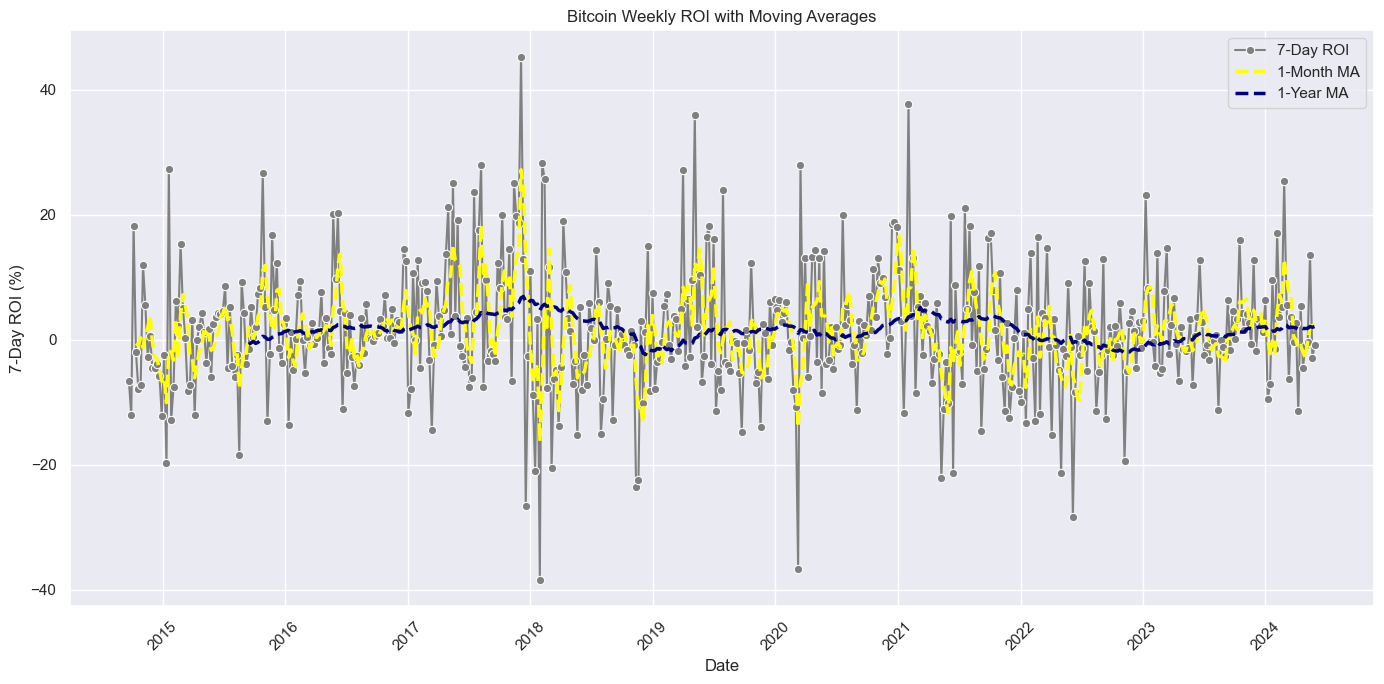

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_weekly_btc_roi(weekly_btc_df):
    """
    Plots the 7-day ROI of Bitcoin along with 1-month and 1-year moving averages.

    Parameters:
    weekly_btc_df (pd.DataFrame): DataFrame containing the 7-day ROI of Bitcoin.
    """
    # Calculate moving averages
    weekly_btc_df['1_Month_MA'] = weekly_btc_df['7_Day_ROI'].rolling(window=4).mean() # 4 weeks in a month 
    weekly_btc_df['1_Year_MA'] = weekly_btc_df['7_Day_ROI'].rolling(window=52).mean()  # 52 weeks in a year

    # Set the plot style
    sns.set(style="darkgrid")

    # Create the plot
    plt.figure(figsize=(14, 7))

    # Plot 7-day ROI
    sns.lineplot(data=weekly_btc_df, x=weekly_btc_df.index, y='7_Day_ROI', marker='o', label='7-Day ROI', color='grey')

    # Plot 1-month moving average
    sns.lineplot(data=weekly_btc_df, x=weekly_btc_df.index, y='1_Month_MA', color='yellow', linestyle='--', linewidth=2.5, label='1-Month MA')

    # Plot 1-year moving average
    sns.lineplot(data=weekly_btc_df, x=weekly_btc_df.index, y='1_Year_MA', color='navy', linestyle='--', linewidth=2.5, label='1-Year MA')

    # Add titles and labels
    plt.title('Bitcoin Weekly ROI with Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('7-Day ROI (%)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_weekly_btc_roi(weekly_btc_df)

## Step 4: Building the Forecasting Model

We will use the Exponential Smoothing model from the `statsmodels` library to forecast Bitcoin 7-day ROI. The model uses previous values of weekly bitcoin returns to predict future values, with the additional condition that more recent values are weighted relatively heavier than less recent values. 

The simple explanation for why this might work is that the model might pick up specific trends or seasonalities that allow us to extrapolate the pattern into the future with some accuracy. 

An exponential smoothing model is defined more formally here: https://otexts.com/fpp2/ses.html.

In [5]:
# Define rolling forecast function for weekly ROI
def rolling_forecast(model_func, data, forecast_steps, rolling_periods):
    forecasted_rois = []
    actual_rois = []
    initial_train_size = len(data) - rolling_periods
    train_set = data[:initial_train_size]
    
    for i in range(rolling_periods):
        test_set_start = initial_train_size + i
        test_set_end = test_set_start + forecast_steps
        
        # Train model on current training set
        model = model_func(train_set)
        
        # Forecast the next week
        forecast = model.forecast(steps=forecast_steps)
        forecasted_roi = forecast.iloc[-1]  # Take the last value of the forecast
        
        # Actual ROI
        actual_roi = data['7_Day_ROI'].iloc[test_set_start]
        
        # Store ROIs
        forecasted_rois.append(forecasted_roi)
        actual_rois.append(actual_roi)
        
        # Update training set with actual data of the forecasted week
        train_set = data[:test_set_end]
    
    # Calculate overall MAE
    mae = mean_absolute_error(actual_rois, forecasted_rois)
    return mae, forecasted_rois, actual_rois

# Model function for weekly ROI data
def weekly_roi_model_func(train):
    # Let's use year seasonality to try to capture the seasonality derived from the bitcoin Halving cycle
    return ExponentialSmoothing(train['7_Day_ROI'], seasonal='add', seasonal_periods=4*12).fit() 

# Backtesting parameters
forecast_steps = 1  # 1 week
rolling_periods = 4  # 4 weeks

# Perform rolling forecast
mae, forecasted_rois, actual_rois = rolling_forecast(weekly_roi_model_func, weekly_btc_df, forecast_steps, rolling_periods)

## Step 5: Evaluating the Model

It's important to evaluate the accuracy of our forecasting model. We will measure the performance using the Mean Absolute Error (MAE). Read more about it here: https://en.wikipedia.org/wiki/Mean_absolute_error.

In [6]:
print(f'mae: {round(mae,2)}%')

mae: 4.21%


Maximum Actual ROI: 13.59
Minimum Actual ROI: -2.87


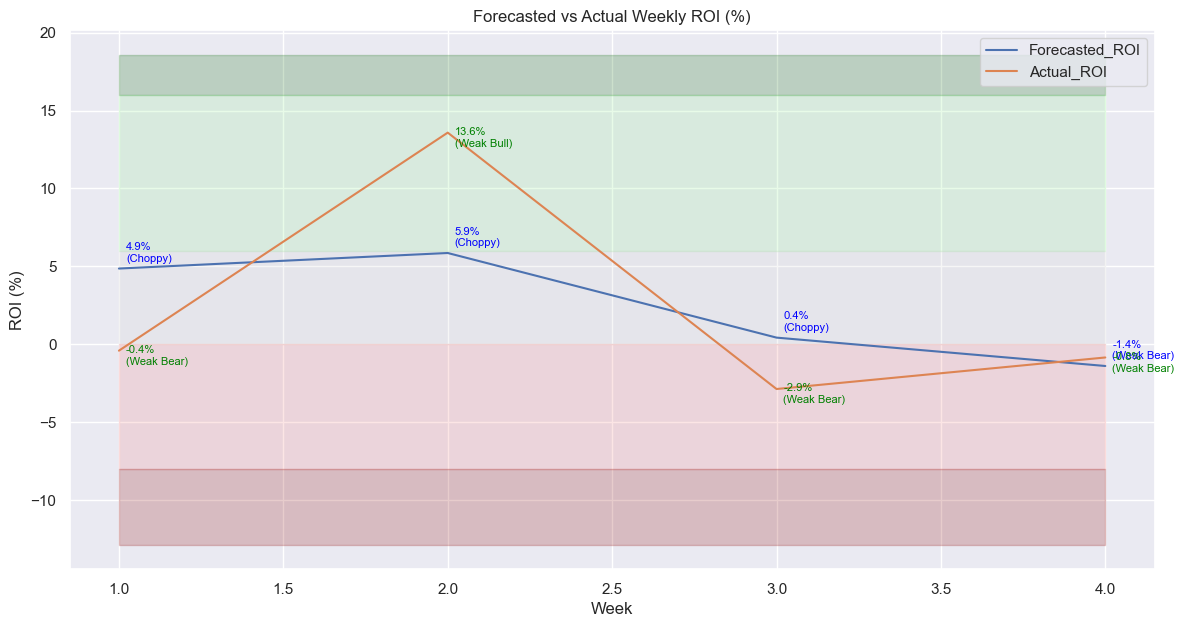

In [7]:
max_roi = max(max(forecasted_rois), max(actual_rois))
print(f"Maximum Actual ROI: {max_roi:.2f}")

min_roi = min(min(forecasted_rois), min(actual_rois))
print(f"Minimum Actual ROI: {min_roi:.2f}")


# Define the states of nature
states_of_nature = {
    "Strong Bull": {"range": (16, max_roi+5), "color": "darkgreen"},
    "Weak Bull": {"range": (6, 16), "color": "lightgreen"},
    "Choppy": {"range": (0, 6), "color": "lightgrey"},
    "Weak Bear": {"range": (-8, 0), "color": "lightcoral"},
    "Strong Bear": {"range": (min_roi-10, -8), "color": "darkred"}
}

# Create a DataFrame for plotting and convert ROI to percentage
results_df = pd.DataFrame({
    'Week': range(1, len(forecasted_rois)+1),
    'Forecasted_ROI': forecasted_rois,
    'Actual_ROI': actual_rois
})

# Function to determine the state of nature based on ROI
def determine_state(roi):
    for state, properties in states_of_nature.items():
        if properties["range"][0] <= roi < properties["range"][1]:
            return state
    return "Unknown"

# Set the plot style
sns.set(style="darkgrid")

# Create the plot
plt.figure(figsize=(14, 7))

# Add shaded regions for states of nature
for state, properties in states_of_nature.items():
    plt.fill_between(
        x=results_df['Week'],
        y1=properties["range"][0],
        y2=properties["range"][1],
        color=properties["color"],
        alpha=0.2,
    )

# Plot the forecasted and actual ROIs
sns.lineplot(x='Week', y='value', hue='variable', 
             data=pd.melt(results_df, ['Week']), 
             markers=True, dashes=False)

# Add annotations for each data point
for i in range(len(results_df)):
    week = results_df['Week'][i]
    forecasted_roi = results_df['Forecasted_ROI'][i]
    actual_roi = results_df['Actual_ROI'][i]
    
    # Determine the state of nature
    forecasted_state = determine_state(forecasted_roi)
    actual_state = determine_state(actual_roi)
    
    # Annotate forecasted ROI
    plt.annotate(
        f'{forecasted_roi:.1f}%\n({forecasted_state})', 
        xy=(week, forecasted_roi), 
        xytext=(5, 5), 
        textcoords='offset points', 
        fontsize=8, 
        color='blue'
    )
    
    # Annotate actual ROI
    plt.annotate(
        f'{actual_roi:.1f}%\n({actual_state})', 
        xy=(week, actual_roi), 
        xytext=(5, -10), 
        textcoords='offset points', 
        fontsize=8, 
        color='green'
    )

# Add titles and labels
plt.title('Forecasted vs Actual Weekly ROI (%)')
plt.xlabel('Week')
plt.ylabel('ROI (%)')
plt.legend()
plt.show()

## Conclusion

Congratulations! You have completed a basic time series forecasting project. This tutorial introduced you to the essential steps involved in forecasting: data collection, preparation, modelling, and evaluation. With these skills, you are ready to tackle the tournament, applying unique and improved data and models to achieve better accuracy.